In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.image as img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow import keras

In [25]:
# Caminho da pasta das imagens, devemos 
#transformar as imagens em vetores para treinarmos na rede neural
folder_path = "../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"
no_images = os.listdir(folder_path + '/no/')
yes_images = os.listdir(folder_path + '/yes/')
dataset=[]
lab=[]
for image_name in no_images:
    image=cv2.imread(folder_path + '/no/' + image_name)
    image=Image.fromarray(image)
    image=image.resize((512,512))
    dataset.append(np.array(image))
    lab.append(0)
    
for image_name in yes_images:
    image=cv2.imread(folder_path + '/yes/' + image_name)
    image=Image.fromarray(image)
    image=image.resize((512,512))
    dataset.append(np.array(image))
    lab.append(1)

In [27]:
X,y = np.array(dataset), np.array(lab) # X conjunto de treino já trnaforma em vetor, y target

In [28]:
#Parte reponsavel por criar novas imagens a partir do dataset original
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=X[0].shape),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

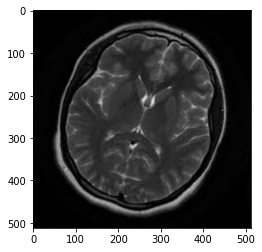

In [29]:
plt.imshow(data_augmentation(X)[10].numpy().astype("uint8")) #nova imagem criada 

In [30]:
rede_google = MobileNetV2(X[0].shape,include_top=False,weights="imagenet") #rede convolucionão do google

In [31]:
rede_google.trainable = False #estou desativando a parte de apredizado da rede_google 
                        #pois eu quero usar os parametros já treinados

In [32]:
rede_google.summary() #veja quantos parametros essa rede tem!!!

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [33]:
media_global = keras.layers.GlobalAveragePooling2D() #Esse comando irá fazer uma media dos parametros
                                                    #da rede convolucional rede_google

In [34]:
predictor = keras.layers.Dense(1) #Neorônio de saida da rede que irá fazer a classificação

In [35]:
MODELO = keras.Sequential([data_augmentation,rede_google,media_global,predictor]) #modelo propriamente configurado

In [36]:
MODELO.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 512, 512, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 16, 16, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
taxa_de_apredizado = 0.001 #eu escolhi essa taxa de aprendizado junto o a função custo sendo a binary cross entropy
MODELO.compile(optimizer=keras.optimizers.RMSprop(learning_rate=taxa_de_apredizado),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])

In [39]:
#divisão entre o conjunto de treino e teste
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.05,random_state=True) 

In [40]:
#treinamento do modelo
MODELO.fit(X_train,Y_train,epochs=80,validation_data=(X_test,Y_test))

Epoch 1/80
8/8 [==============================] - 6s 465ms/step - loss: 0.6665 - accuracy: 0.5417 - val_loss: 0.5497 - val_accuracy: 0.7692
Epoch 2/80
8/8 [==============================] - 2s 194ms/step - loss: 0.6216 - accuracy: 0.6667 - val_loss: 0.6842 - val_accuracy: 0.3846
Epoch 3/80
8/8 [==============================] - 2s 192ms/step - loss: 0.6212 - accuracy: 0.5500 - val_loss: 0.5325 - val_accuracy: 0.7692
Epoch 4/80
8/8 [==============================] - 2s 195ms/step - loss: 0.5937 - accuracy: 0.6792 - val_loss: 0.5004 - val_accuracy: 0.7692
Epoch 5/80
8/8 [==============================] - 2s 197ms/step - loss: 0.5860 - accuracy: 0.6833 - val_loss: 0.5011 - val_accuracy: 0.9231
Epoch 6/80
8/8 [==============================] - 2s 192ms/step - loss: 0.5710 - accuracy: 0.6917 - val_loss: 0.5180 - val_accuracy: 0.7692
Epoch 7/80
8/8 [==============================] - 2s 192ms/step - loss: 0.5470 - accuracy: 0.7917 - val_loss: 0.4910 - val_accuracy: 0.7692
Epoch 8/80
8/8 [====